In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import periodogram, square, firwin
from scipy.stats import linregress
from scipy.io import loadmat
import scipy.stats

from sklearn.cross_decomposition import CCA
from statsmodels.tsa.arima_model import ARMA

from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

In [9]:
DATA = np.array([
    loadmat(f'data/s{subject_id}.mat')['train'][:, :8, :, :] #Discard non-EEG-occipital channels (8+)
    for subject_id in range(4, 12)
])
num_subjects, num_targets, num_channels, N, num_trials = DATA.shape

fs = 256
N_pre, N_dur, N_post = 74, 1024, 16
T_pre, T_dur, T_post = [n / fs for n in (N_pre, N_dur, N_post)]
t = np.array([x / fs for x in range(-N_pre, -N_pre + N)])

target_freqs = [9.25 + (x % 3) * 2 + int(x / 3) * 0.5 for x in range(num_targets)]

print(f"Subjects:          {num_subjects}")
print(f"Classes:           {num_targets}")
print(f"EEG Channels:      {num_channels}")
print(f"Time Samples:      {N}")
print(f"Trials per Class:  {num_trials}")

Subjects:          8
Classes:           12
EEG Channels:      8
Time Samples:      1114
Trials per Class:  15


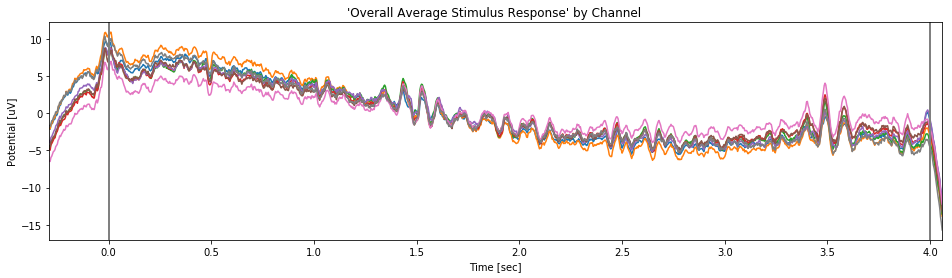

In [10]:
plt.figure(figsize=(16, 4))
for ch in range(num_channels):
    y = DATA[:, :, ch, :, :].mean(axis=(0, 1, 3))
    plt.plot(np.array([x/fs for x in range(-N_pre, -N_pre + N)]), y - y.mean())
    plt.axvline(x=0, color='gray')
    plt.axvline(x=4, color='gray')
    plt.xlim(-T_pre, T_dur + T_post - 1/fs)
    plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
    plt.title("'Overall Average Stimulus Response' by Channel ");

data = DATA.mean(axis=2); #Merge channels

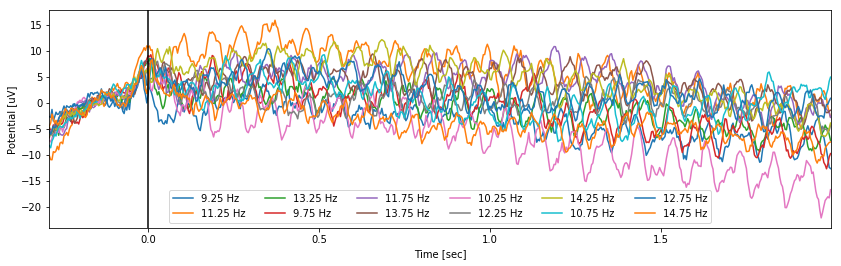

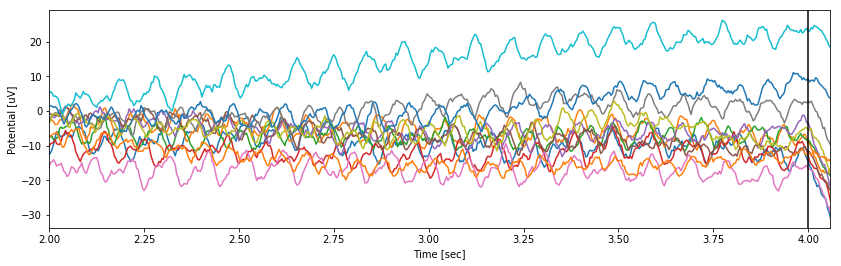

In [11]:
epoch_avgs = data.mean(axis=(0, 3))

plt.figure(figsize=(14, 4))
for ix, freq in enumerate(target_freqs[:]):
    mid_ix = int(N_pre + 2 * fs)
    plt.plot(t[:mid_ix], epoch_avgs[ix, :mid_ix] - epoch_avgs[ix, :N_pre].mean(axis=0), label=f"{freq} Hz")
plt.xlim(-T_pre, 2 - 1/fs)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
plt.legend(loc='lower center', ncol=6)
plt.axvline(x=0, color='black');

plt.figure(figsize=(14, 4))
for ix, freq in enumerate(target_freqs):
    mid_ix = int(N_pre + 2 * fs)
    plt.plot(t[mid_ix:], epoch_avgs[ix, mid_ix:] - epoch_avgs[ix, :N_pre].mean(axis=0))
plt.xlim(2, T_dur + T_post - 1/fs)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
plt.axvline(x=T_dur, color='black');

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 0 - 128 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          1.3014, 1.7243                                          
                                                                                                  
                                       29 peaks were found:                                       
          

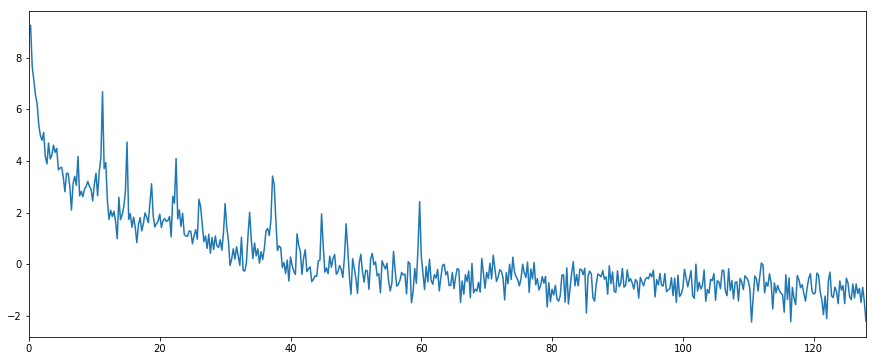

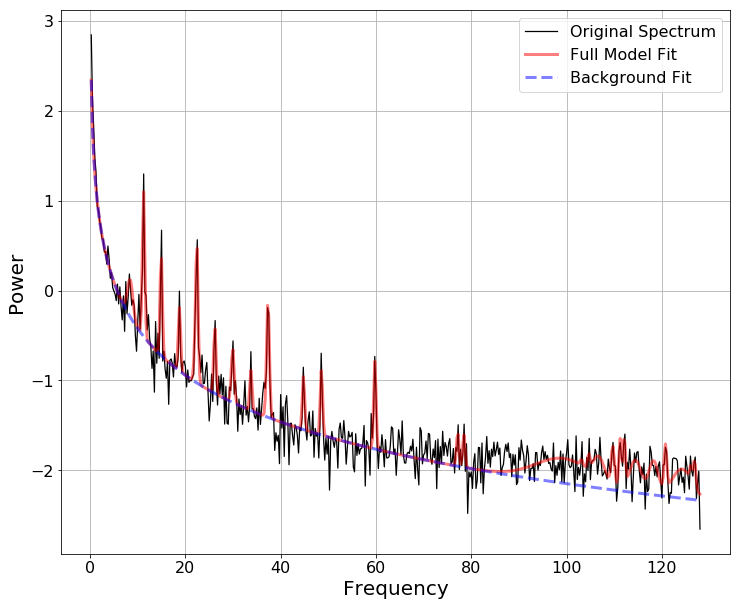

In [12]:
f_trial, Pxx_trials = periodogram(data[:, :, N_pre:-N_post, :].mean(axis=3), fs=fs, axis=2)

plt.figure(figsize=(15, 6))
plt.xlim(0, fs/2)

target_ix = 1

y = np.log(Pxx_trials[:, :, 1:]).mean(axis=0)
plt.plot(f_trial[1:], y[target_ix, :] - y.mean());

model = FOOOF(min_peak_amplitude=0.3, max_n_peaks=30)
model.report(f_trial[1:], Pxx_trials[:, target_ix, 1:].mean(axis=0))

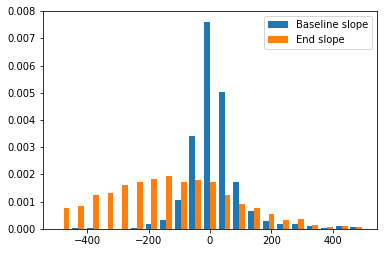

In [13]:
l = []
m = []
for s_ix in range(num_subjects):
    for f_ix in range(num_targets):
        for tr_ix in range(num_trials):
            l.append( linregress(x=t[:N_pre], y=data[s_ix, f_ix, :N_pre, tr_ix])[0] )
for s_ix in range(num_subjects):
    for f_ix in range(num_targets):
        for tr_ix in range(num_trials):
            m.append( linregress(x=t[-N_post:], y=data[s_ix, f_ix, -N_post:, tr_ix])[0] )
plt.hist([l, m], bins=21, range=(-500, 500), density=True, label=["Baseline slope", "End slope"])
plt.legend();

In [14]:
### DETRENDING + LINEAR-REGRESSION
lowpass_cutoff = 1
lowpass_fir = firwin(3*fs+1, lowpass_cutoff, fs=fs, pass_zero=False)

AC_fir = firwin(3*fs+1, (59.5, 60.5), fs=fs, pass_zero = True)

## Simulate single-trial low-reject filtering
s = []
for s_ix in range(num_subjects):
    f = []
    for f_ix in range(num_targets):
        ts = []
        for tr_ix in range(num_trials):
            y_temp = data[s_ix, f_ix, :, tr_ix] - data[s_ix, f_ix, :, tr_ix].mean()
            slope, intercept, _, _, _ = linregress(x=t[:N_pre], y=y_temp[:N_pre])
            slope_corrected = y_temp - (np.pad(t[:N_pre] * slope, (0, N - N_pre), 'constant') + intercept) #Straighten BL
            ts.append( np.convolve(   np.convolve(slope_corrected, lowpass_fir, 'same'),  AC_fir, 'same') ) # Filter epoch
        f.append( np.array(ts).T )
    s.append( np.array(f) )
data_detrended = np.array(s)
print(data_detrended.shape)

(8, 12, 1114, 15)


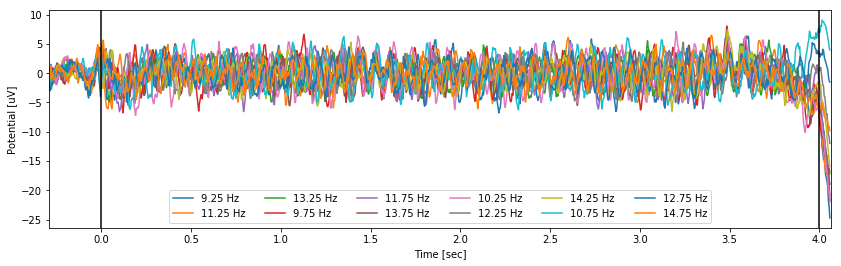

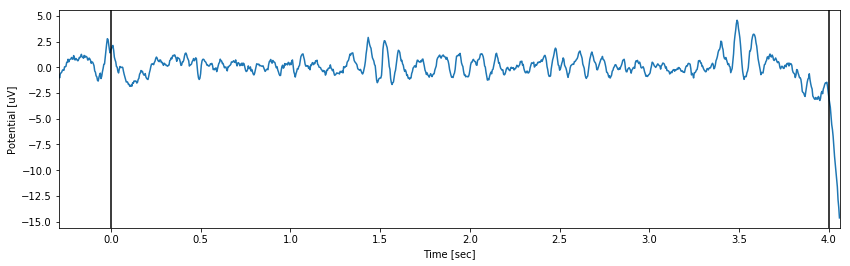

In [15]:
pts = []
plt.figure(figsize=(14, 4))
for ix, freq in enumerate(target_freqs):
    plt.plot(t, data_detrended[:, ix, :, :].mean(axis=(0, 2)), label = f"{freq} Hz")
plt.xlim(-T_pre, T_dur + T_post)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]")
plt.legend(loc='lower center', ncol=6)
plt.axvline(x=0, color='black');
plt.axvline(x=T_dur, color='black');

plt.figure(figsize=(14, 4))
plt.plot(t, data_detrended.mean(axis=(0, 1, 3)) - data_detrended.mean(axis=(0, 1, 3)).mean(axis=0).mean());
plt.xlim(-T_pre, T_dur + T_post)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]")
plt.axvline(x=0, color='black');
plt.axvline(x=T_dur, color='black');

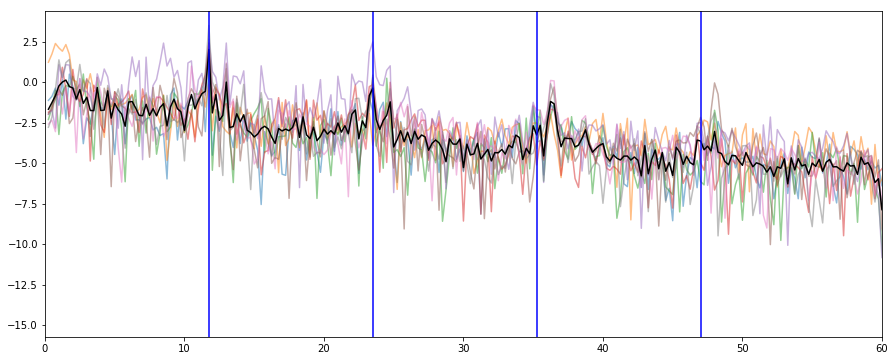

In [16]:
f_trial, Pxx_trials = periodogram(data_detrended[:, :, N_pre:-N_post, :].mean(axis=3), fs=fs, axis=2)

target_ix = 4

y = np.log(Pxx_trials[:, :, 1:])

plt.figure(figsize=(15, 6))
plt.xlim(0, fs/2)
for subject_ix in range(num_subjects):
    plt.plot(f_trial[1:], y[subject_ix, target_ix, :], alpha=0.5);
plt.plot(f_trial[1:], y[:, target_ix, :].mean(axis=0), 'black');
plt.xlim(0, 60)

h = 9.25 + (target_ix % 3) * 2 + int(target_ix / 3) * 0.5
for harmonic in range(4):
    plt.axvline(x=h*(harmonic+1), color='blue')

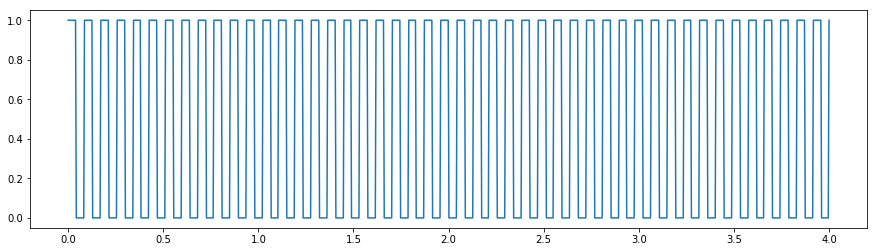

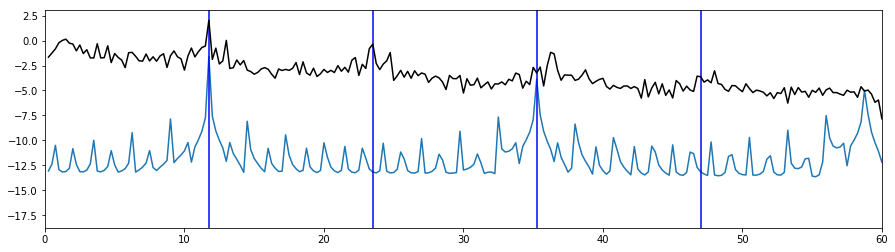

In [17]:
ex_hz = 9.25 + (target_ix % 3) * 2 + int(target_ix / 3) * 0.5
ex_fs = 256
ex_T  = 4

ex_t_scaled = np.linspace(0, 2 * np.pi * (ex_hz * ex_T), ex_fs * ex_T)
ex_y = square(ex_t_scaled) / 2 + 0.5
ex_t = ex_t_scaled / (2 * np.pi * ex_hz)
plt.figure(figsize=(15, 4))
plt.plot(ex_t, ex_y)

ex_f, ex_Pxx = periodogram(ex_y, fs=ex_fs, scaling='spectrum')
plt.figure(figsize=(15, 4))
plt.plot(ex_f[1:], np.log(ex_Pxx[1:]));
plt.xlim(0, 60)

for harmonic in range(4):
    plt.axvline(x=ex_hz*(harmonic+1), color='blue')

plt.plot(f_trial[1:], y[:, target_ix, :].mean(axis=0), 'black');

In [18]:
num_harmonics = 2

def canonical_correlation(x, y):
    X_c, Y_c = CCA(n_components=1).fit_transform(x, y)
    return scipy.stats.pearsonr(X_c.flatten(), Y_c.flatten())[0]

Y = []
for stim_freq in target_freqs:
    Y_n = []
    for h in range(num_harmonics):
        Y_n.append( np.sin(2 * np.pi * (h+1) * stim_freq * t) )
        Y_n.append( np.cos(2 * np.pi * (h+1) * stim_freq * t) )
    Y.append( np.array(Y_n) )

res = np.zeros((3, num_subjects, num_targets, num_trials))
for app_ix, app in enumerate([(False, False), (True, False), (True, True),]):
    detrend, AR = app
    for subject_ix in range(num_subjects):
        print(f'[DT:{detrend}, AR:{AR}] Sbj.{subject_ix}...\t', end='')
        for freq_ix in range(num_targets):
            for trial_ix in range(num_trials):
                X_hat = DATA[subject_ix, freq_ix, :, :, trial_ix]

                if detrend:
                    for ch_ix in range(num_channels):
                        X_hat[ch_ix] -= X_hat[ch_ix].mean()
                        X_hat[ch_ix] = np.convolve(X_hat[ch_ix], lowpass_fir, 'same')
                        X_hat[ch_ix] = np.convolve(X_hat[ch_ix], AC_fir, 'same')
                
                if AR:
                    X_hat = X_hat.mean(axis=0)
                    slope, intercept, _, _, _ = linregress(x=t[:N_pre], y=X_hat[:N_pre])
                    X_hat -= (np.pad(t[:N_pre] * slope, (0, N - N_pre), 'constant') + intercept)
                    model = ARIMA(X_hat[:N_pre:2], order=(10, 0, 0)).fit(trend='nc')
                    forecast, _, _ = model.forecast(int((N_dur + N_post)/2))
                    X_hat -= np.pad(np.repeat(forecast, 2), (N_pre, 0), 'constant')

                rho = [canonical_correlation(Y[n].T, X_hat.T) for n in range(num_targets)]
                res[app_ix, subject_ix, freq_ix, trial_ix] = int(np.argmax(rho) == freq_ix)
        print('DONE')

[DT:False, AR:False] Sbj.0...	DONE
[DT:False, AR:False] Sbj.1...	DONE
[DT:False, AR:False] Sbj.2...	DONE
[DT:False, AR:False] Sbj.3...	DONE
[DT:False, AR:False] Sbj.4...	DONE
[DT:False, AR:False] Sbj.5...	DONE
[DT:False, AR:False] Sbj.6...	DONE
[DT:False, AR:False] Sbj.7...	DONE
[DT:True, AR:False] Sbj.0...	DONE
[DT:True, AR:False] Sbj.1...	DONE
[DT:True, AR:False] Sbj.2...	DONE
[DT:True, AR:False] Sbj.3...	DONE
[DT:True, AR:False] Sbj.4...	DONE
[DT:True, AR:False] Sbj.5...	DONE
[DT:True, AR:False] Sbj.6...	DONE
[DT:True, AR:False] Sbj.7...	DONE
[DT:True, AR:True] Sbj.0...	

NameError: name 'ARIMA' is not defined

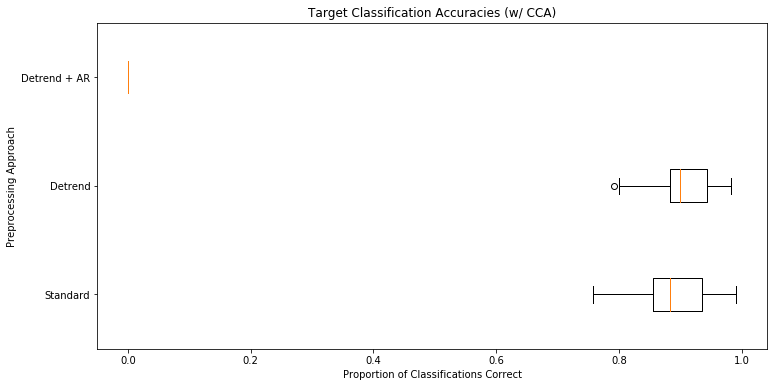

In [19]:
boxes = []; labels = []
for app_ix, app in enumerate([(False, False), (True, False), (True, True)]):
    detrend, AR = app
    boxes.append([
        res[app_ix, :, f_ix, :].mean()
        for f_ix in range(num_targets)
    ])
    labels.append(
        f"{('','Standard')[not (detrend or AR)]}{('','Detrend')[detrend]}{('',' + AR')[detrend and AR]}"
    )

plt.figure(figsize=(12, 6))
plt.title("Target Classification Accuracies (w/ CCA)")
plt.xlabel("Proportion of Classifications Correct"); plt.ylabel("Preprocessing Approach")
plt.boxplot(boxes, labels=labels, vert=False);

# Note: Classification accuracy decreases with target frequency